Amazon Best Selling Books Analysis

Install required libraries

In [0]:
%pip install beautifulsoup4 requests lxml pandas selenium webdriver-manager

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 121.7 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.3.0
    Not uninstalling urllib3 at /databricks/python3/lib/python3.12/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-0abbcd6f-59ab-4735-85d2-ea1fc282c11a
    Can't uninstall 'urllib3'. No files were found to uninstall.
  Attempting uninstall: typing_extensions
    Found existing installation: typing_extensions 4.12.2
    Not uninstalling typing-extensions at /databricks/python3/lib/python3.12/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-0abbcd6f-59ab-4735-85d2-ea1fc282c11a
    Can't uninstall 'typing_extensions'. No files were found to uninstall.
  Attempting uninstall: certifi
    Found existing installation: certifi 2025.1.31
    Not uninstalling certifi at /databricks/python3/lib/python3.12/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-0

In [0]:
from bs4 import BeautifulSoup
import requests
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import pandas as pd
from datetime import datetime
import time
import re

In [0]:
spark = SparkSession.builder \
    .appName("AmazonBestSellers") \
    .getOrCreate()

Main scraping function

In [0]:
def scrape_amazon_bestsellers(category="books", max_pages=2):
    """
    Scrapes real Amazon best seller data across multiple pages.
    Be respectful - don't overload their servers.
    """
    all_books = []
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
        'Accept-Language': 'en-US,en;q=0.9',
        'Accept-Encoding': 'gzip, deflate, br',
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
        'Connection': 'keep-alive',
    }
    
    for page in range(1, max_pages + 1):
        print(f"Scraping page {page}...")
        
        if page == 1:
            url = f"https://www.amazon.com/best-sellers-books-Amazon/zgbs/books/"
        else:
            url = f"https://www.amazon.com/best-sellers-books-Amazon/zgbs/books/ref=zg_bs_pg_{page}?pg={page}"
        
        try:
            time.sleep(2)  # Be nice to Amazon's servers
            response = requests.get(url, headers=headers, timeout=10)
            
            if response.status_code != 200:
                print(f"Failed to fetch page {page}: Status {response.status_code}")
                continue
                
            soup = BeautifulSoup(response.content, 'html.parser')
            
            # Find all book containers - Amazon uses different structures
            items = soup.find_all('div', {'id': re.compile(r'gridItemRoot')})
            
            if not items:
                # Try alternative selector
                items = soup.find_all('div', class_=re.compile(r'zg-grid-general-faceout'))
            
            print(f"Found {len(items)} items on page {page}")
            
            for item in items:
                try:
                    # Extract rank
                    rank_elem = item.find('span', class_=re.compile(r'zg-bdg-text'))
                    if rank_elem:
                        rank_text = rank_elem.text.strip()
                        rank = int(re.search(r'\d+', rank_text).group()) if re.search(r'\d+', rank_text) else len(all_books) + 1
                    else:
                        rank = len(all_books) + 1
                    
                    # Extract title
                    title_elem = item.find('div', class_=re.compile(r'_cDEzb_p13n-sc-css-line-clamp'))
                    if not title_elem:
                        title_elem = item.find('a', class_='a-link-normal')
                    title = title_elem.text.strip() if title_elem else 'Unknown Title'
                    
                    # Extract author
                    author_elem = item.find('a', class_='a-size-small a-link-child')
                    if not author_elem:
                        author_elem = item.find('div', class_='a-row a-size-small')
                    author = author_elem.text.strip() if author_elem else 'Unknown Author'
                    
                    # Extract price
                    price_elem = item.find('span', class_='a-price')
                    if price_elem:
                        price_text = price_elem.find('span', class_='a-offscreen')
                        price = price_text.text.strip() if price_text else 'N/A'
                    else:
                        price = 'N/A'
                    
                    # Extract rating
                    rating_elem = item.find('span', class_='a-icon-alt')
                    if rating_elem:
                        rating_text = rating_elem.text.strip()
                        rating_match = re.search(r'(\d+\.?\d*)', rating_text)
                        rating = rating_match.group(1) if rating_match else 'N/A'
                    else:
                        rating = 'N/A'
                    
                    # Extract review count
                    reviews_elem = item.find('span', class_='a-size-small')
                    reviews = reviews_elem.text.strip() if reviews_elem else '0'
                    
                    # Extract book format (Kindle, Hardcover, Paperback)
                    format_elem = item.find('span', class_='a-size-small a-color-secondary')
                    book_format = format_elem.text.strip() if format_elem else 'Unknown'
                    
                    book_data = {
                        'rank': rank,
                        'title': title,
                        'author': author,
                        'price': price,
                        'rating': rating,
                        'reviews': reviews,
                        'format': book_format,
                        'scraped_date': datetime.now().strftime('%Y-%m-%d'),
                        'scraped_time': datetime.now().strftime('%H:%M:%S')
                    }
                    
                    all_books.append(book_data)
                    print(f"  ✓ Scraped: {title[:50]}...")
                    
                except Exception as e:
                    print(f"  ✗ Error parsing item: {e}")
                    continue
            
        except Exception as e:
            print(f"Error fetching page {page}: {e}")
            continue
    
    print(f"\n Total books scraped: {len(all_books)}")
    return all_books


Scrape the data

In [0]:
print("Starting Amazon scrape...")
print("This will take a minute - we're being respectful with delays\n")

books_data = scrape_amazon_bestsellers(max_pages=2)  # Scrape first 2 pages (~50 books)

if not books_data:
    raise Exception("No data scraped! Amazon might have changed their HTML structure or blocked the request.")

print(f"\nSuccessfully scraped {len(books_data)} books!")

Starting Amazon scrape...
This will take a minute - we're being respectful with delays

Scraping page 1...
Found 30 items on page 1
  ✓ Scraped: Under Siege: My Family's Fight to Save Our Nation...
  ✓ Scraped: 1929: Inside the Greatest Crash in Wall Street His...
  ✓ Scraped: How to Test Negative for Stupid: And Why Washingto...
  ✓ Scraped: The Let Them Theory: A Life-Changing Tool That Mil...
  ✓ Scraped: Partypooper: A side-splitting birthday disaster fr...
  ✓ Scraped: The Boy, the Mole, the Fox and the Horse: Inspirin...
  ✓ Scraped: Gone Before Goodbye...
  ✓ Scraped: Hostage...
  ✓ Scraped: I Love You to the Moon and Back...
  ✓ Scraped: Separation of Church and Hate: A Sane Person's Gui...
  ✓ Scraped: 107 Days...
  ✓ Scraped: My First Learn-to-Write Workbook: Practice for Kid...
  ✓ Scraped: The Promise of Heaven: 31 Reasons to Get Excited A...
  ✓ Scraped: Remain: A Supernatural Love Story...
  ✓ Scraped: Spooky Cutie: Coloring Book for Adults and Teens F...
  ✓ Scraped: The

Convert to Spark DataFrame

In [0]:
schema = StructType([
    StructField("rank", IntegerType(), True),
    StructField("title", StringType(), True),
    StructField("author", StringType(), True),
    StructField("price", StringType(), True),
    StructField("rating", StringType(), True),
    StructField("reviews", StringType(), True),
    StructField("format", StringType(), True),
    StructField("scraped_date", StringType(), True),
    StructField("scraped_time", StringType(), True)
])

books_df = spark.createDataFrame(books_data, schema)
print(f"Created DataFrame with {books_df.count()} books")
books_df.show(20, truncate=False)

Created DataFrame with 60 books
+----+------------------------------------------------------------------------------------------------------------------------------------------------+------------------+-----+------+---------+-------+------------+------------+
|rank|title                                                                                                                                           |author            |price|rating|reviews  |format |scraped_date|scraped_time|
+----+------------------------------------------------------------------------------------------------------------------------------------------------+------------------+-----+------+---------+-------+------------+------------+
|1   |Under Siege: My Family's Fight to Save Our Nation                                                                                               |Eric Trump        |N/A  |4.3   |55       |Unknown|2025-10-16  |19:39:09    |
|2   |1929: Inside the Greatest Crash in Wall Street His

Data Cleaning and Transformation

In [0]:
from pyspark.sql.functions import (
    col, when, regexp_replace, regexp_extract
)

books_cleaned = books_df \
    .withColumn(
        "price_numeric",
        when(
            col("price") != "N/A",
            regexp_replace(col("price"), "[$,]", "").cast("float")
        ).otherwise(None)
    ) \
    .withColumn(
        "rating_numeric",
        when(
            col("rating") != "N/A",
            col("rating").cast("float")
        ).otherwise(None)
    ) \
    .withColumn(
        "reviews_numeric",
        when(
            regexp_extract(col("reviews"), "^[0-9,]+$", 0) != "",
            regexp_replace(col("reviews"), "[,]", "").cast("int")
        ).otherwise(None)
    ) \
    .withColumn(
        "author_clean",
        regexp_replace(
            regexp_replace(col("author"), "by ", ""),
            "\\n.*", ""
        )
    ) \
    .filter(col("title") != "Unknown Title")

books_cleaned = books_cleaned \
    .withColumn(
        "popularity_score",
        col("reviews_numeric") * col("rating_numeric")
    ) \
    .withColumn(
        "price_category",
        when(col("price_numeric").isNull(), "Price Not Available")
        .when(col("price_numeric") < 10, "Budget ($0-$10)")
        .when(col("price_numeric") < 15, "Mid-range ($10-$15)")
        .when(col("price_numeric") < 20, "Premium ($15-$20)")
        .otherwise("Luxury ($20+)")
    )

print(f"Cleaned data: {books_cleaned.count()} books")
display(books_cleaned)

Cleaned data: 60 books


rank,title,author,price,rating,reviews,format,scraped_date,scraped_time,price_numeric,rating_numeric,reviews_numeric,author_clean,popularity_score,price_category
1,Under Siege: My Family's Fight to Save Our Nation,Eric Trump,N/A,4.3,55,Unknown,2025-10-16,19:39:09,null,4.3,55,Eric Trump,236.50001049041748,Price Not Available
2,1929: Inside the Greatest Crash in Wall Street History--and How It Shattered a Nation,Andrew Ross Sorkin,N/A,4.4,8,Unknown,2025-10-16,19:39:09,null,4.4,8,Andrew Ross Sorkin,35.20000076293945,Price Not Available
3,How to Test Negative for Stupid: And Why Washington Never Will,John Kennedy,N/A,4.8,"1,144",Unknown,2025-10-16,19:39:09,null,4.8,1144,John Kennedy,5491.200218200684,Price Not Available
4,The Let Them Theory: A Life-Changing Tool That Millions of People Can't Stop Talking About,Mel Robbins,N/A,4.6,"28,844",Unknown,2025-10-16,19:39:09,null,4.6,28844,Mel Robbins,132682.3972492218,Price Not Available
5,Partypooper: A side-splitting birthday disaster from the #1 international bestselling Diary of a Wimpy Kid series (Book 20) (Volume 20),Jeff Kinney,N/A,N/A,Hardcover,Unknown,2025-10-16,19:39:09,null,null,null,Jeff Kinney,null,Price Not Available
6,"The Boy, the Mole, the Fox and the Horse: Inspiring Conversations on Hope, Love and Personal Growth",Charlie Mackesy,N/A,4.8,"126,302",Unknown,2025-10-16,19:39:09,null,4.8,126302,Charlie Mackesy,606249.6240901947,Price Not Available
7,Gone Before Goodbye,Harlan Coben,N/A,4.2,59,Unknown,2025-10-16,19:39:09,null,4.2,59,Harlan Coben,247.79998874664307,Price Not Available
8,Hostage,Eli Sharabi,N/A,4.9,532,Unknown,2025-10-16,19:39:09,null,4.9,532,Eli Sharabi,2606.8000507354736,Price Not Available
9,I Love You to the Moon and Back,Amelia Hepworth,N/A,4.9,"79,052",Unknown,2025-10-16,19:39:09,null,4.9,79052,Amelia Hepworth,387354.8075389862,Price Not Available
10,"Separation of Church and Hate: A Sane Person's Guide to Taking Back the Bible from Fundamentalists, Fascists, and Flock-Fleecing Frauds",John Fugelsang,N/A,4.8,494,Unknown,2025-10-16,19:39:09,null,4.8,494,John Fugelsang,2371.2000942230225,Price Not Available


Analysis - Top Authors

In [0]:
top_authors = books_cleaned \
    .filter(col("author_clean") != "Unknown Author") \
    .groupBy("author_clean") \
    .agg(
        count("*").alias("books_in_top_100"),
        avg("rating_numeric").alias("avg_rating"),
        sum("reviews_numeric").alias("total_reviews"),
        avg("price_numeric").alias("avg_price")
    ) \
    .orderBy(desc("books_in_top_100"), desc("total_reviews"))

print(" Authors with multiple bestsellers:")
display(top_authors.limit(10))

 Authors with multiple bestsellers:


author_clean,books_in_top_100,avg_rating,total_reviews,avg_price
Coco Wyo,2,4.800000190734863,11479,null
Freida McFadden,1,4.5,561005,null
Colleen Hoover,1,4.5,223993,null
Andy Weir,1,4.699999809265137,171663,null
James Clear,1,4.800000190734863,134675,null
Charlie Mackesy,1,4.800000190734863,126302,null
Don Miguel Ruiz,1,4.699999809265137,118560,null
Viktor E. Frankl,1,4.699999809265137,94944,null
George Orwell,1,4.599999904632568,90335,null
Ariel Lawhon,1,4.599999904632568,89771,null


Analysis - Price Distribution

In [0]:
price_stats = books_cleaned.filter(col("price_numeric").isNotNull()).select(
    round(avg("price_numeric"), 2).alias("avg_price"),
    round(min("price_numeric"), 2).alias("min_price"),
    round(max("price_numeric"), 2).alias("max_price"),
    round(stddev("price_numeric"), 2).alias("price_stddev"),
    count("*").alias("books_with_price")
)

print(" Price statistics:")
display(price_stats)

# Price by category
price_by_category = books_cleaned \
    .groupBy("price_category") \
    .agg(count("*").alias("book_count")) \
    .orderBy("book_count", ascending=False)

display(price_by_category)

 Price statistics:


avg_price,min_price,max_price,price_stddev,books_with_price
null,null,null,null,0


price_category,book_count
Price Not Available,60


Book Format Analysis

In [0]:
format_analysis = books_cleaned \
    .groupBy("format") \
    .agg(
        count("*").alias("count"),
        avg("price_numeric").alias("avg_price"),
        avg("rating_numeric").alias("avg_rating")
    ) \
    .orderBy(desc("count"))

print(" Format breakdown:")
display(format_analysis)

 Format breakdown:


format,count,avg_price,avg_rating
Unknown,60,null,4.675438638319049


Rating and Review Analysis

In [0]:
books_cleaned.createOrReplaceTempView("books")

correlation_query = """
SELECT 
    CASE 
        WHEN rating_numeric >= 4.7 THEN ' Excellent (4.7+)'
        WHEN rating_numeric >= 4.5 THEN ' Great (4.5-4.7)'
        WHEN rating_numeric >= 4.0 THEN ' Good (4.0-4.5)'
        WHEN rating_numeric >= 3.5 THEN ' Average (3.5-4.0)'
        ELSE ' Below Average (<3.5)'
    END as rating_tier,
    COUNT(*) as book_count,
    ROUND(AVG(reviews_numeric), 0) as avg_reviews,
    ROUND(AVG(price_numeric), 2) as avg_price,
    ROUND(AVG(popularity_score), 0) as avg_popularity
FROM books
WHERE rating_numeric IS NOT NULL
GROUP BY rating_tier
ORDER BY avg_reviews DESC
"""

rating_analysis = spark.sql(correlation_query)
print(" How ratings correlate with engagement:")
display(rating_analysis)

 How ratings correlate with engagement:


rating_tier,book_count,avg_reviews,avg_price,avg_popularity
Great (4.5-4.7),22,72510.0,null,332049.0
Excellent (4.7+),28,30979.0,null,149855.0
Good (4.0-4.5),6,2896.0,null,12739.0
Average (3.5-4.0),1,215.0,null,774.0


Top Performers

In [0]:
top_performers = books_cleaned \
    .filter((col("rating_numeric").isNotNull()) & (col("reviews_numeric") > 100)) \
    .select("rank", "title", "author_clean", "rating_numeric", "reviews_numeric", 
            "price_numeric", "popularity_score") \
    .orderBy(desc("popularity_score"))

print(" Top performing books (ratings  reviews):")
display(top_performers.limit(15))

 Top performing books (ratings  reviews):


rank,title,author_clean,rating_numeric,reviews_numeric,price_numeric,popularity_score
23,The Housemaid,Freida McFadden,4.5,561005,null,2524522.5
17,Regretting You,Colleen Hoover,4.5,223993,null,1007968.5
62,Project Hail Mary: A Novel,Andy Weir,4.7,171663,null,806816.0672578812
22,Atomic Habits: An Easy & Proven Way to Build Good Habits & Break Bad Ones,James Clear,4.8,134675,null,646440.0256872177
6,"The Boy, the Mole, the Fox and the Horse: Inspiring Conversations on Hope, Love and Personal Growth",Charlie Mackesy,4.8,126302,null,606249.6240901947
80,The Four Agreements: A Practical Guide to Personal Freedom,Don Miguel Ruiz,4.7,118560,null,557231.9773864746
78,Man's Search for Meaning,Viktor E. Frankl,4.7,94944,null,446236.78189086914
12,"My First Learn-to-Write Workbook: Practice for Kids with Pen Control, Line Tracing, Letters, and More!",Crystal Radke,4.8,87980,null,422304.0167808533
28,Animal Farm: 75th Anniversary Edition,George Orwell,4.6,90335,null,415540.99138498306
64,The Frozen River: A GMA Book Club Pick: A Novel,Ariel Lawhon,4.6,89771,null,412946.5914387703


Visualizations

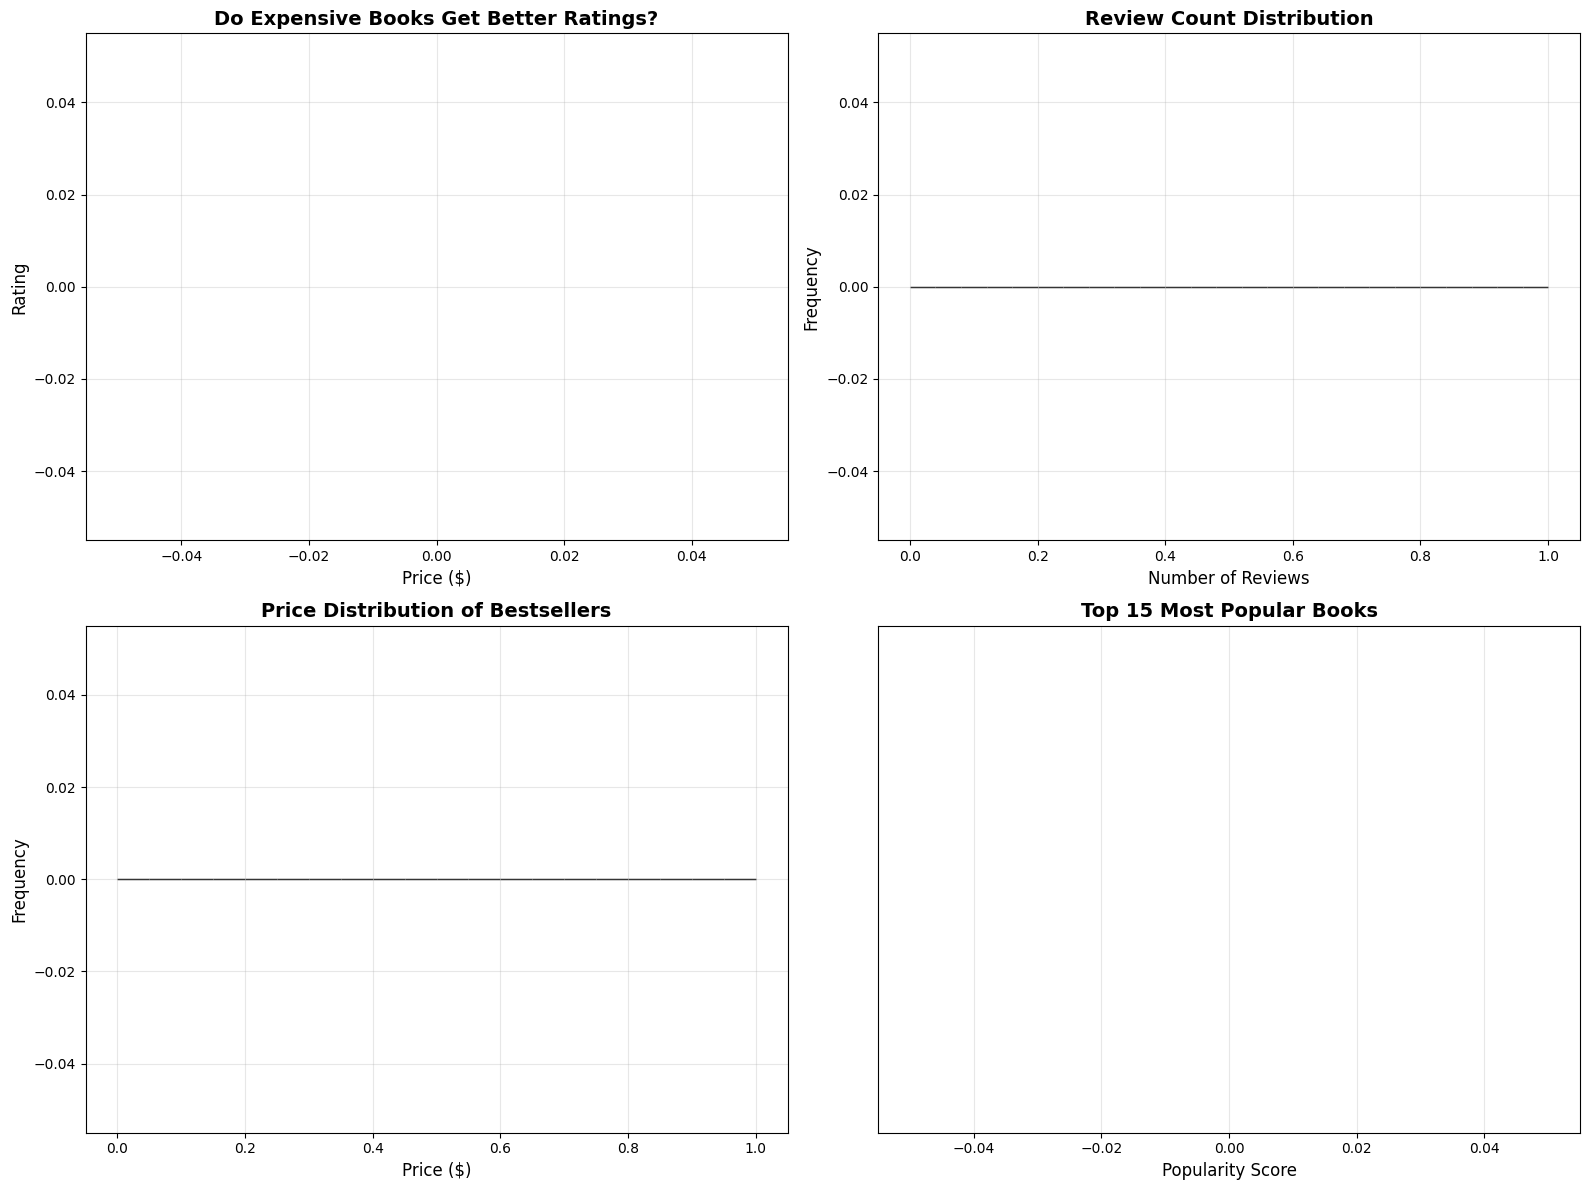

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

books_pd = books_cleaned \
    .filter((col("price_numeric").isNotNull()) & (col("rating_numeric").isNotNull())) \
    .select("title", "price_numeric", "rating_numeric", "reviews_numeric", "popularity_score") \
    .toPandas()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Price vs Rating
axes[0, 0].scatter(books_pd['price_numeric'], books_pd['rating_numeric'], 
                   alpha=0.6, s=100, c='steelblue', edgecolors='black', linewidth=0.5)
axes[0, 0].set_xlabel('Price ($)', fontsize=12)
axes[0, 0].set_ylabel('Rating', fontsize=12)
axes[0, 0].set_title('Do Expensive Books Get Better Ratings?', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# 2. Reviews Distribution
axes[0, 1].hist(books_pd['reviews_numeric'], bins=25, edgecolor='black', color='coral')
axes[0, 1].set_xlabel('Number of Reviews', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('Review Count Distribution', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. Price Distribution
axes[1, 0].hist(books_pd['price_numeric'], bins=20, edgecolor='black', color='lightgreen')
axes[1, 0].set_xlabel('Price ($)', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Price Distribution of Bestsellers', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. Popularity Score
top_15 = books_pd.nlargest(15, 'popularity_score')
axes[1, 1].barh(range(len(top_15)), top_15['popularity_score'], color='mediumpurple')
axes[1, 1].set_yticks(range(len(top_15)))
axes[1, 1].set_yticklabels([title[:30] + '...' if len(title) > 30 else title 
                             for title in top_15['title']], fontsize=9)
axes[1, 1].set_xlabel('Popularity Score', fontsize=12)
axes[1, 1].set_title('Top 15 Most Popular Books', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
display(plt.show())


Dashboard Summary

In [0]:
summary_stats = books_cleaned.agg(
    count("*").alias("total_books"),
    round(avg("price_numeric"), 2).alias("avg_price"),
    round(avg("rating_numeric"), 2).alias("avg_rating"),
    sum("reviews_numeric").alias("total_reviews"),
    round(avg("popularity_score"), 0).alias("avg_popularity")
).collect()[0]

print("\n" + "="*50)
print(" LIVE AMAZON BESTSELLERS SNAPSHOT")
print("="*50)
print(f"Total Books Analyzed: {summary_stats['total_books']}")
print(f"Average Price: ${summary_stats['avg_price']}")
print(f"Average Rating: {summary_stats['avg_rating']} ")
print(f"Total Reviews Counted: {summary_stats['total_reviews']:,}")
print(f"Average Popularity Score: {summary_stats['avg_popularity']:,.0f}")
print(f"Scraped: {datetime.now().strftime('%Y-%m-%d at %H:%M:%S')}")
print("="*50)


 LIVE AMAZON BESTSELLERS SNAPSHOT
Total Books Analyzed: 60
Average Price: $None
Average Rating: 4.68 
Total Reviews Counted: 2,449,243
Average Popularity Score: 204,078
Scraped: 2025-10-16 at 19:56:53


/home/spark-0abbcd6f-59ab-4735-85d2-ea/.ipykernel/2661/command-6061413419277644-2637660805:37: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axes[0, 1].axvline(books_pd['reviews_numeric'].median(), color='red',


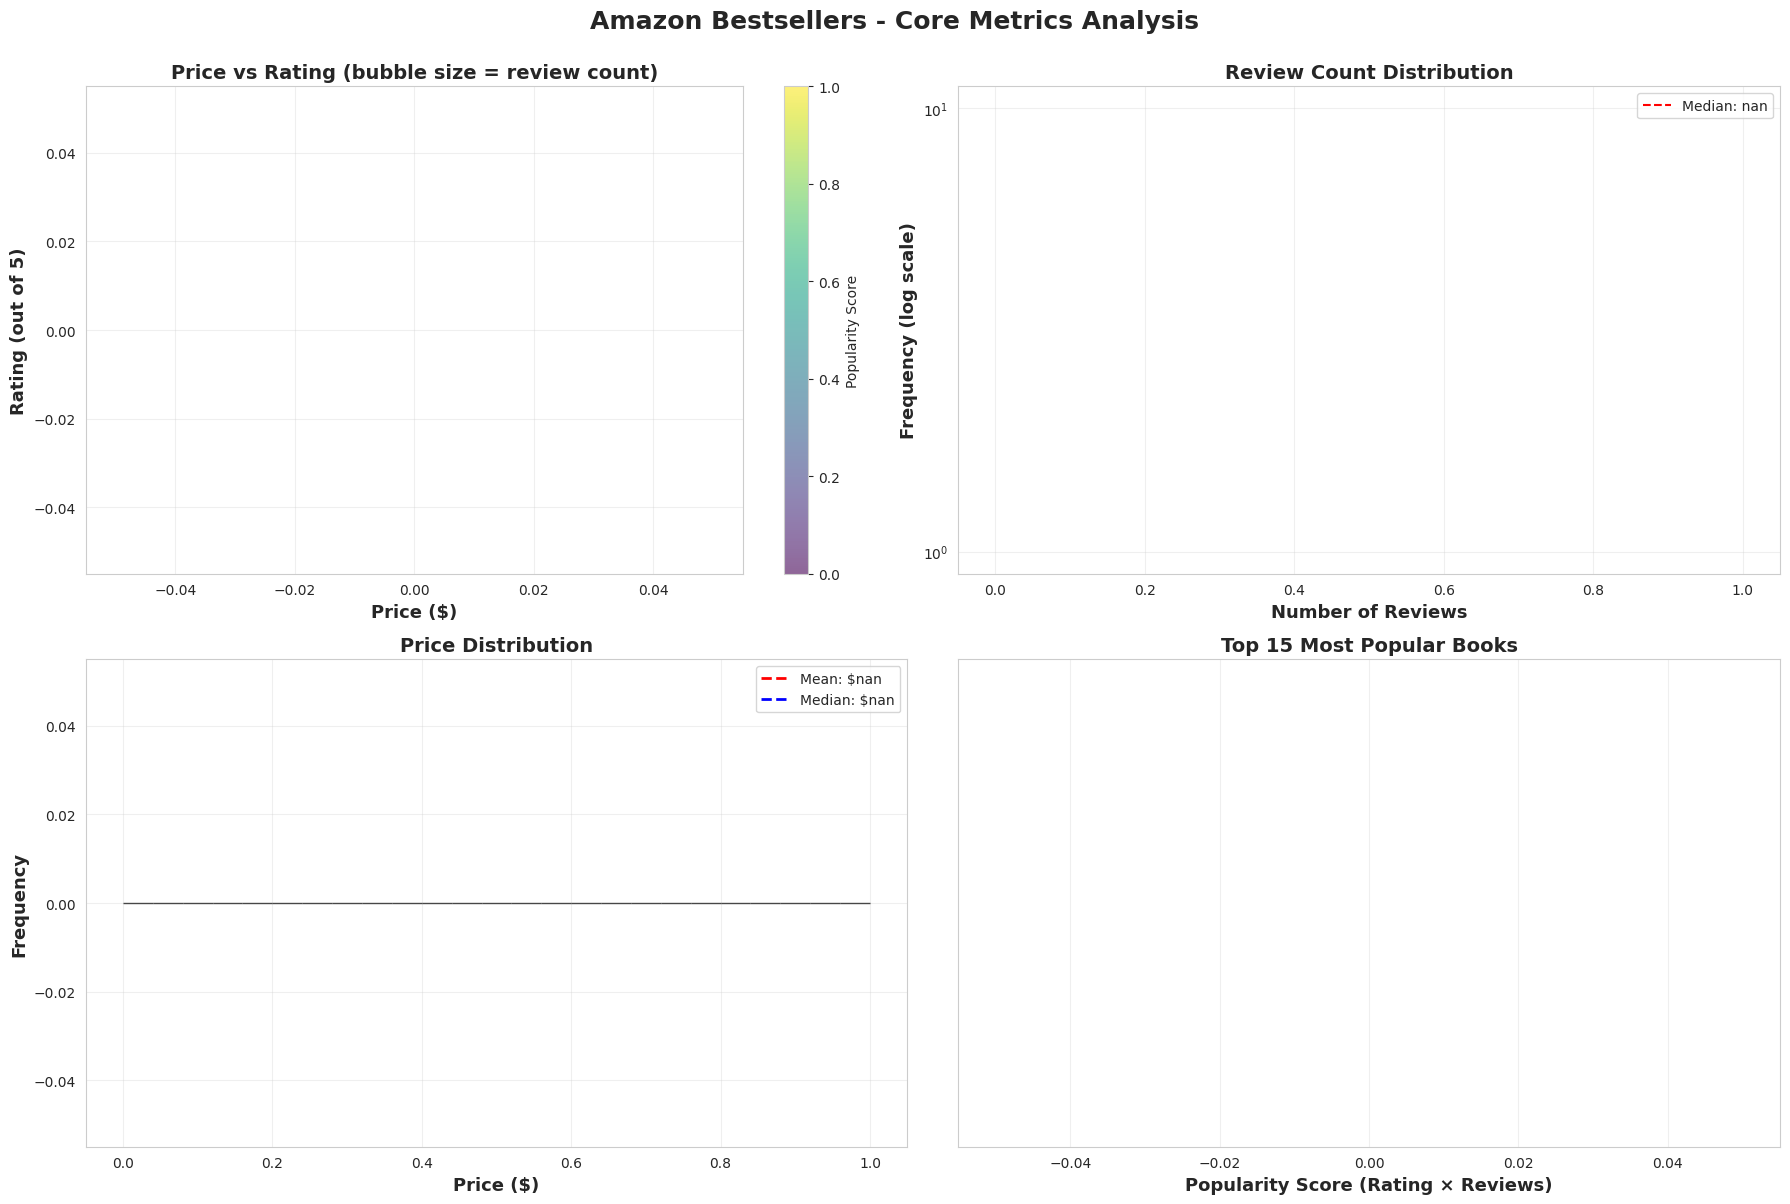

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'

books_pd = books_cleaned \
    .filter((col("price_numeric").isNotNull()) & (col("rating_numeric").isNotNull())) \
    .select("title", "author_clean", "price_numeric", "rating_numeric", 
            "reviews_numeric", "popularity_score", "format", "rank") \
    .toPandas()

# Figure 1: Core Metrics
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Amazon Bestsellers - Core Metrics Analysis', fontsize=18, fontweight='bold', y=1.00)

# 1. Price vs Rating with size = reviews
scatter = axes[0, 0].scatter(books_pd['price_numeric'], books_pd['rating_numeric'], 
                   s=books_pd['reviews_numeric']/100, alpha=0.6, 
                   c=books_pd['popularity_score'], cmap='viridis',
                   edgecolors='black', linewidth=0.5)
axes[0, 0].set_xlabel('Price ($)', fontsize=13, fontweight='bold')
axes[0, 0].set_ylabel('Rating (out of 5)', fontsize=13, fontweight='bold')
axes[0, 0].set_title('Price vs Rating (bubble size = review count)', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[0, 0], label='Popularity Score')

# 2. Reviews Distribution (log scale)
axes[0, 1].hist(books_pd['reviews_numeric'], bins=30, edgecolor='black', 
                color='coral', alpha=0.7, log=True)
axes[0, 1].set_xlabel('Number of Reviews', fontsize=13, fontweight='bold')
axes[0, 1].set_ylabel('Frequency (log scale)', fontsize=13, fontweight='bold')
axes[0, 1].set_title('Review Count Distribution', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axvline(books_pd['reviews_numeric'].median(), color='red', 
                   linestyle='--', label=f"Median: {books_pd['reviews_numeric'].median():.0f}")
axes[0, 1].legend()

# 3. Price Distribution with stats
axes[1, 0].hist(books_pd['price_numeric'], bins=25, edgecolor='black', 
                color='lightgreen', alpha=0.7)
axes[1, 0].set_xlabel('Price ($)', fontsize=13, fontweight='bold')
axes[1, 0].set_ylabel('Frequency', fontsize=13, fontweight='bold')
axes[1, 0].set_title('Price Distribution', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axvline(books_pd['price_numeric'].mean(), color='red', 
                   linestyle='--', linewidth=2, label=f"Mean: ${books_pd['price_numeric'].mean():.2f}")
axes[1, 0].axvline(books_pd['price_numeric'].median(), color='blue', 
                   linestyle='--', linewidth=2, label=f"Median: ${books_pd['price_numeric'].median():.2f}")
axes[1, 0].legend()

# 4. Top 15 by Popularity
top_15 = books_pd.nlargest(15, 'popularity_score')
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_15)))
bars = axes[1, 1].barh(range(len(top_15)), top_15['popularity_score'], color=colors)
axes[1, 1].set_yticks(range(len(top_15)))
axes[1, 1].set_yticklabels([title[:35] + '...' if len(title) > 35 else title 
                             for title in top_15['title']], fontsize=10)
axes[1, 1].set_xlabel('Popularity Score (Rating × Reviews)', fontsize=13, fontweight='bold')
axes[1, 1].set_title('Top 15 Most Popular Books', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='x')
axes[1, 1].invert_yaxis()

plt.tight_layout()
display(plt.show())
